# Introduction

**Quick description**

The code that follows deploys an ensemble of pre-trained computer vision neural network models that are fine-tuned to the task of age classification of bollywood celebrities into YOUNG, MIDDLE and OLD classes from their facial images. The solution is highly inspired from a course on deep learning offered by fastai ([reference](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)) and has been built by using kaggle notebook



**Dataset reference**

The dataset used for the task has been taken from a practice challenge on the analytics vidya portal and linked [here](https://datahack.analyticsvidhya.com/contest/practice-problem-age-detection/#About). Once the data is downloaded, make sure that you unzip the training and test data sets along with storing their respective folders in a local directory.

Please assign the name of this local directory to the **input path** variable as shown in the following line

***input_path = '/kaggle/input/age-estimate' (<-- replace this path)***

Please ensure that the GPU accelerators are activated for the training operation to ensure that the training time is reasonable

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import shutil

# Organization of the training and test data sets

The original training dataset can be **split into train, validation and a holdout data sets** for the purpose of the learning and performance measurement. The holdout dataset would be used only at a final stage to determine the accuracy of the model and the potential for it to generalize on a population of the facial image data set

The model has been designed using fastai which requires **training images to be organized across folders representing their respective class labels**. Hence the first step would involve reorganization of the input image files in a suitable folder structure using the steps detailed below

1.  Create file path pointers to extract the training images from the inputs and display a sample image to ensure that the internal library stack is functioning as per the expectation

(69, 70)


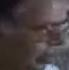

In [2]:
input_path = '/kaggle/input/age-estimate'
path = Path(input_path)
train_path = (path/'train')
trn_images_path = (train_path/'Train')
trn_images = get_image_files(trn_images_path)
im = PILImage.create(trn_images[1])
print(im.size)
im.to_thumb(128)

2. The dataset also consists of a csv file which indicates the mapping between each image file and the corresponding age class label. The set of **mappings can be split into training samples and holdout samples**.

In [3]:
train_df = pd.read_csv(train_path/'train.csv')
X_train,X_test,y_train,y_test = train_test_split(train_df['ID'],train_df['Class'],test_size=0.25,stratify=train_df['Class'].to_list())
X_train.head()

3094     2697.jpg
7694    10088.jpg
4712    18084.jpg
3684    12043.jpg
6542     6666.jpg
Name: ID, dtype: object

3. The image samples corresponding to the **holdout set** (called as test set) can be **copied to a separate location** for measuring performance later on. When running it locally, **users can set the test_path to a directory path of their choice**. The copy function of the shutil library can be used to perform the copy operation

In [4]:
test_path = Path('/kaggle/working/test')
test_path.mkdir(exist_ok=True)
for img in X_test.to_list():
    src_path = (trn_images_path/img)
    dest_path = test_path
    shutil.copy(src_path,dest_path)
print('Done')

Done


4. As a part of the setup for the training procedure, a **folder structure** can be created comprising of **one folder store each for the age class labels**. Users can **set the new_path variable** to any local directory path of their choice

In [5]:
new_path = Path('/kaggle/working/')
new_path = (new_path/'train')
new_path.mkdir(exist_ok=True)
class_names = train_df['Class'].unique().tolist()

for cn in class_names:
    dst_path = (new_path/cn)
    dst_path.mkdir(exist_ok=True)

5. The training image files can be copied now from the inputs folder to their respective age group folders

In [6]:
for i,img in enumerate(X_train.to_list()):
    src_path = (trn_images_path/img)
    dst_path = (new_path/y_train.iloc[i])
    shutil.copy(src_path,dst_path)
print('Done')

Done


In [7]:
trn_images_path = new_path
trn_images = get_image_files(trn_images_path)

# The Training Approach

1. A quick code snippet can help in determination of the image size distribution. This is helpful to get a sense of the pre-processing transformations that can be applied before subjecting the image pixels to computer vision learning algorithms

In [8]:
from fastcore.parallel import *
def sizing(o): return PILImage.create(o).size
img_sizing = parallel(sizing,trn_images,n_workers=8)
pd.Series(img_sizing).value_counts()

(36, 56)      42
(37, 54)      35
(26, 36)      17
(29, 39)      16
(30, 44)      14
              ..
(91, 95)       1
(96, 92)       1
(110, 108)     1
(144, 209)     1
(116, 157)     1
Length: 8370, dtype: int64

2. For ease of reusability, the entire training logic has been wrapped in a function which leverages fastai libraries for the following purposes:
    * The **ImageDataLoaders class** can be used to translate the image pixels into suitable batches for training the learning algorithms that leverage computer vision architectures. The **pre-processing stages of resizing and augmentation** are also applied to the training images at this point in time so that the **learning algorithms develop invariance** to operations such as flipping, rotation, resizing, lighting changes, etc.
    * The **arch function parameter** is used to indicate the **pre-trained computer vision architecture** of a model that can be fine-tuned to the specific task of age classification. In fine-tuning, all the layers in the a given model are not subjected to the training procedure. Only **the head of the model (the last layer)** is trained for updating the associated activations to the task under consideration
    * A **vision_learner object** of the fastai library can be used as an abstraction layer to orchestrate the entire training procedure given suitable values for dataloaders, metrics, number of epochs and learning rate
    * **Gradient Accumulation** has been leveraged in the model to ensure that the **limited GPU memory is efficiently used** even with achieving larger effective batch sizes (In this case, the gradients are accumulated for the accum number of training steps instead of being reset to zero after each training step)
    * **Test time augmentation** (tta) is applied on the test/holdout dataset while determining the likelihood of each age category to improve the accuracy of classification

In [9]:
def create_learner(arch,test_images,item_tfms=Resize(64,method='squish'),size = 64,epoch=5,bs=128,
                  accum=1,fine_tune=True):
    img_dls = ImageDataLoaders.from_folder(trn_images_path,valid_pct=0.25,item_tfms = item_tfms,
                                           batch_tfms = aug_transforms(size=size,min_scale=0.75),bs=bs//accum)
    cbs=GradientAccumulation(bs) if accum else []
    learner = vision_learner(img_dls,arch,metrics=error_rate,path='.',cbs=cbs).to_fp16()
    if fine_tune:
        learner.fine_tune(epoch,1e-2)
        return learner.tta(dl=learner.dls.test_dl(test_images))
    else:
        learner.unfreeze()
        learner.fit_one_cycle(epoch,1e-2)

3. An ensemble of models corresponding to the computer vision architectures of **resnet, convnext and vit** have been leveraged for improving the accuracy of age classification. A dictionary corresponding to the architecture checkpoints discussed above and their suitable preprocessing steps can be used to achieve the ensemble learning operation

In [10]:
model_archs={
    'vit_base_patch32_224':{(Resize(224,method='squish'),224)},
    'convnext_small_in22k':{(Resize(64,method='crop'),64)},
    'resnet26d':{(Resize((128,48),method=ResizeMethod.Pad,pad_mode=PadMode.Zeros),128)}
}

4. The **likelihood of age category prediction** obtained on the test/holdout data from training the learner with each of the **computer vision models** discussed earlier can be stored within the tta_preds list. The vision models corresponding to the various architectures are trained on invocation of the create_learner function

In [11]:
import gc
test_images = get_image_files(test_path)
tta_preds=[]
for arch,model_config in model_archs.items():
    for it_config,b_size in model_config:
        print(f'---{arch}')
        tta_preds.append(create_learner(arch=arch,test_images=test_images,item_tfms=it_config,
                            size = b_size,epoch=6,bs=128,accum=2))
        gc.collect()
        torch.cuda.empty_cache()

---vit_base_patch32_224


epoch,train_loss,valid_loss,error_rate,time
0,0.799465,0.654585,0.252144,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.529594,0.444388,0.177385,00:49
1,0.467745,0.392407,0.152197,00:48
2,0.373987,0.412893,0.162915,00:49
3,0.249990,0.326172,0.114952,00:48
4,0.170600,0.277375,0.098339,00:49
5,0.128895,0.279947,0.098071,00:48


---convnext_small_in22k


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.879887,0.757710,0.285102,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.649176,0.578344,0.229904,00:40
1,0.597208,0.544382,0.204180,00:40
2,0.505389,0.476329,0.188639,00:40
3,0.416057,0.407254,0.159432,00:42
4,0.357772,0.397391,0.155681,00:40
5,0.320371,0.387572,0.153269,00:53


---resnet26d


epoch,train_loss,valid_loss,error_rate,time
0,1.162088,0.903574,0.407556,00:45


epoch,train_loss,valid_loss,error_rate,time
0,0.889139,0.790403,0.351822,00:45
1,0.851702,0.774945,0.328242,00:46
2,0.821372,0.737682,0.322883,00:45
3,0.760975,0.673610,0.291533,00:46
4,0.721261,0.665561,0.284566,00:45
5,0.687496,0.644856,0.277063,00:46


# Accuracy determination on the holdout dataset

1. The **age category that generates the highest likelihood value** for a given image is taken to be the **predicted age category** for that image. The predicted age category labels can then be stored as a pandas series named 'Class'

In [12]:
tta_arr = first(zip(*tta_preds))
avg_preds = torch.stack(tta_arr).mean(0)
class_idx = avg_preds.argmax(dim=1)

img_dls = ImageDataLoaders.from_folder(trn_images_path,valid_pct=0.25,item_tfms = Resize(64,method='squish'),
                                           batch_tfms = aug_transforms(size=64,min_scale=0.75),bs=1024)
learner_proxy = vision_learner(img_dls,'resnet26d',metrics=error_rate).to_fp16()
vocab = np.array(learner_proxy.dls.vocab)

results = pd.Series(vocab[class_idx],name='Class')

2. The age predictions can then be joined with the test dataset to ensure that the predicted age category is aligned correctly actual age category for each test image. With this piece of information, the accuracy of the model can be determined

In [13]:
test_image_fl = os.listdir(test_path)
test_image = pd.Series(test_image_fl,name='ID')
out_results = pd.concat([test_image,results],axis=1)
out = pd.merge(X_test,out_results,how='left',left_on='ID',right_on='ID')
out.head()

,ID,Class
0,10654.jpg,MIDDLE
1,14359.jpg,MIDDLE
2,14759.jpg,YOUNG
3,25471.jpg,MIDDLE
4,6443.jpg,MIDDLE


In [14]:
Class = out['Class']
print(f'Accuracy of the model is:{accuracy_score(y_test,Class)}')

Accuracy of the model is:0.9007434197307616


An accuracy of ~90% is possible with the given model configuration. 

***The accuracy can be improved further by leveraging architectures with the potential for higher prediction accuracy as outlined in this article.*** The more complicated architectures require higher computing resources for classification